# pettingZoo库的Simple Adversary环境：抢地标

**动作集合：向四周移动一格 OR 不采取动作**

在这个环境中，有1个对手(红色)，N个好的代理(绿色)，N个路标(默认N=2)。**所有代理观察地标和其他代理的位置**。一个地标是“目标地标”(绿色)。优秀的代理会根据他们中**最接近目标地标的距离**获得奖励，但会根据**对手离目标地标的距离**获得负面奖励。对手根据与目标的距离获得奖励，但它不知道哪个地标是目标地标。所有奖励都是未缩放的欧几里得距离 -- **欺骗对抗智能体**

Agent observation space: [self_pos, self_vel, goal_rel_position, landmark_rel_position, other_agent_rel_positions]

Adversary observation space: [landmark_rel_position, other_agents_rel_positions]


*对LLM的连接理解：挑战自然语言心理博弈*

与传统博弈论处理方式区别：类似的环境Combat中存在必胜态和必败态，双方不一定必定选择最优决策。博弈论去分析切比雪夫距离在多少是必胜态来制定最有决策，而强化学习直接学习决策方式。而此环境使用欧几里得距离，且考虑对手剩下的距离，且对手不知道目标，使得用博弈论设计难度大大提高，体现出强化学习面向决策的优势。
但其实当下的RL已经吸收了博弈论的精华来建模env

https://pettingzoo.farama.org/environments/mpe/simple_adversary/

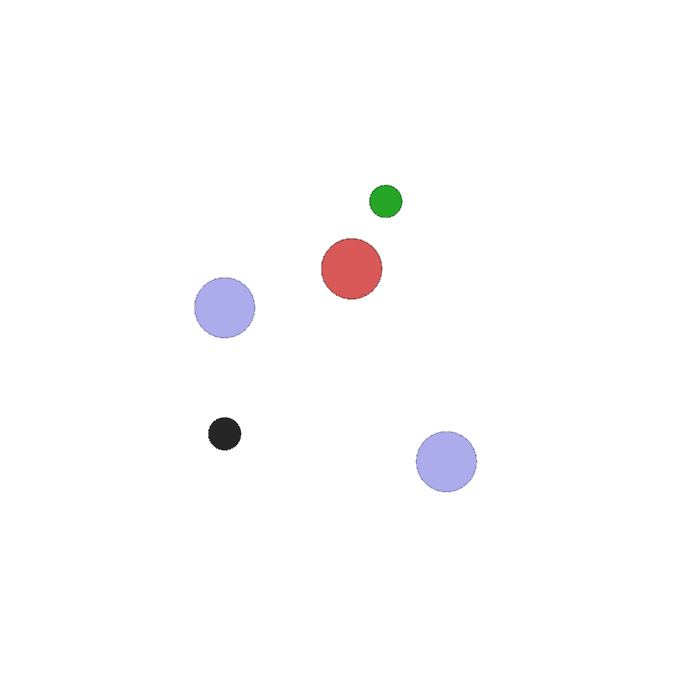

In [1]:
from pettingzoo.mpe import simple_adversary_v3

PettingZoo 的AEC和Parallel Env:https://zhuanlan.zhihu.com/p/660884211 


这里使用Parallel：AECEnv 类是为 Agent-Environment Cycle (AEC) 设计的，它一次只能处理一个 agent 的 action。它的 step 方法接受单个 agent 的 action，并执行该 action。然后，它会自动将控制权切换到下一个 agent。ParallelEnv 类是为并行环境设计的，它可以同时处理所有活动 agents 的 actions。它的 step 方法接受一个包含所有活动 agents actions 的字典，并一次性执行所有这些 actions。

Included PettingZoo wrappers currently do not support parallel environments, to use them you must convert your environment to AEC, apply the wrapper, and convert back to parallel.

env = simple_adversary_v3.env(render_mode="human")

env.reset(seed=42)

for agent in env.agent_iter():
    observation, reward, termination, truncation, info = env.last()

    if termination or truncation:
        action = None
    else:
        # this is where you would insert your policy
        action = env.action_space(agent).sample()

    env.step(action)
env.close()


## 示例

In [2]:
env = simple_adversary_v3.parallel_env()
observations, infos = env.reset()

In [3]:
while env.agents:
    # this is where you would insert your policy
    actions = {agent: env.action_space(agent).sample() for agent in env.agents}
    print(actions)
    observations, rewards, terminations, truncations, infos = env.step(actions)
env.close()

{'adversary_0': 4, 'agent_0': 0, 'agent_1': 3}
{'adversary_0': 0, 'agent_0': 3, 'agent_1': 2}
{'adversary_0': 2, 'agent_0': 1, 'agent_1': 0}
{'adversary_0': 2, 'agent_0': 0, 'agent_1': 2}
{'adversary_0': 1, 'agent_0': 3, 'agent_1': 2}
{'adversary_0': 3, 'agent_0': 2, 'agent_1': 0}
{'adversary_0': 0, 'agent_0': 0, 'agent_1': 2}
{'adversary_0': 2, 'agent_0': 2, 'agent_1': 2}
{'adversary_0': 3, 'agent_0': 0, 'agent_1': 1}
{'adversary_0': 3, 'agent_0': 3, 'agent_1': 1}
{'adversary_0': 2, 'agent_0': 3, 'agent_1': 4}
{'adversary_0': 3, 'agent_0': 4, 'agent_1': 2}
{'adversary_0': 1, 'agent_0': 0, 'agent_1': 4}
{'adversary_0': 3, 'agent_0': 4, 'agent_1': 1}
{'adversary_0': 0, 'agent_0': 2, 'agent_1': 2}
{'adversary_0': 3, 'agent_0': 2, 'agent_1': 2}
{'adversary_0': 3, 'agent_0': 0, 'agent_1': 2}
{'adversary_0': 0, 'agent_0': 0, 'agent_1': 4}
{'adversary_0': 3, 'agent_0': 0, 'agent_1': 2}
{'adversary_0': 4, 'agent_0': 1, 'agent_1': 2}
{'adversary_0': 1, 'agent_0': 0, 'agent_1': 1}
{'adversary_0

# MADDPG(Multi-agent Deep determinisitic policy gradient)

MADDPG是一种中心化训练，去中心化执行(centralized training with decentralized execution, CTDE)方法，基于Actor-Critic。在训练时用一些单个智能体看不到的全局信息以达到更好的训练效果，而在执行时不使用这些信息，每个智能体完全根据自己的策略直接动作(策略模型推断)以达到去中心化执行的效果(先读历史再出来做事)。

MADDPG对每个智能体实现一个DDPG算法，所有智能体共享一个中心化的Critic网络，该Critic网络在训练的过程中同时对每个智能体的Actor网络给出指导，而执行时每个智能体的Actor网络则完全独立做出动作。

## 应用场景建模
部分可观测马尔可夫博弈(Partially observable Markov game):

S -> N个智能体所有可能的状态空间 --- global

P -> 环境的状态转移函数：$S \times \prod_{i=1}^{N}A_i -> w(S) --- global$

$A_i, O_i, \pi_{\theta_i}, r_i$ --- each agent
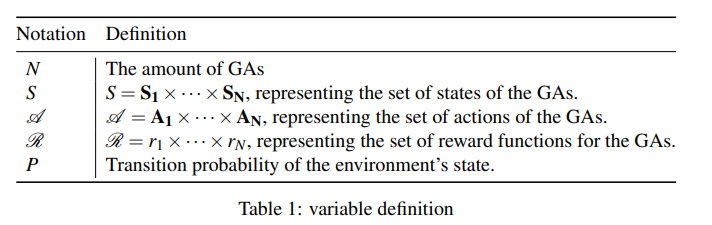
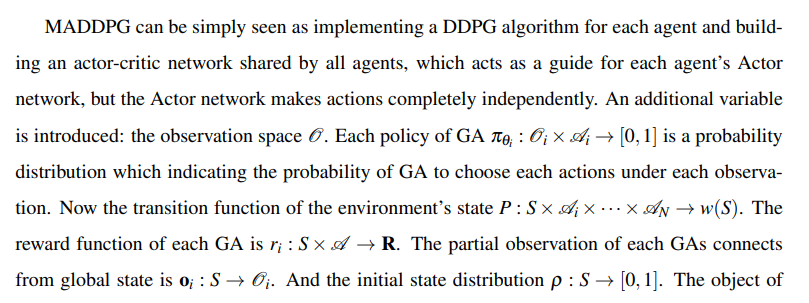
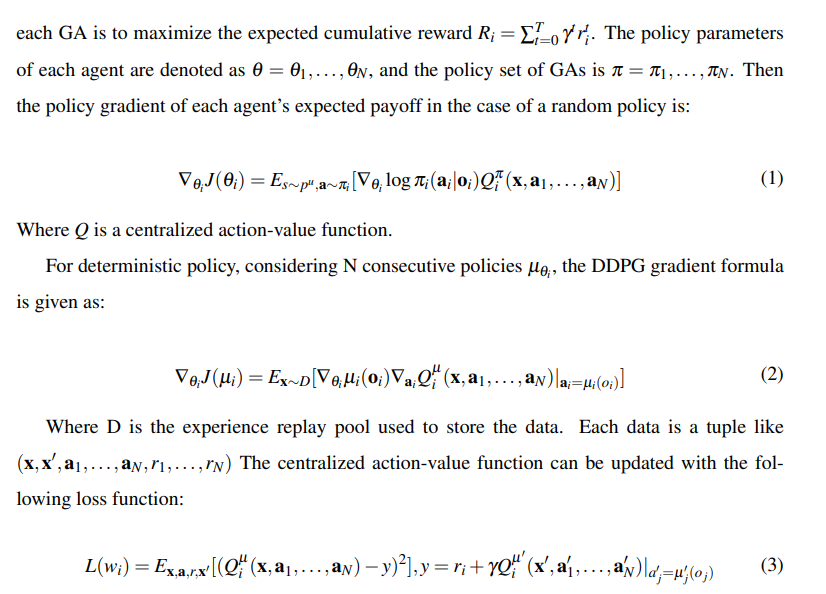
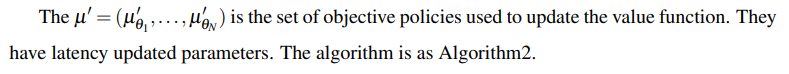
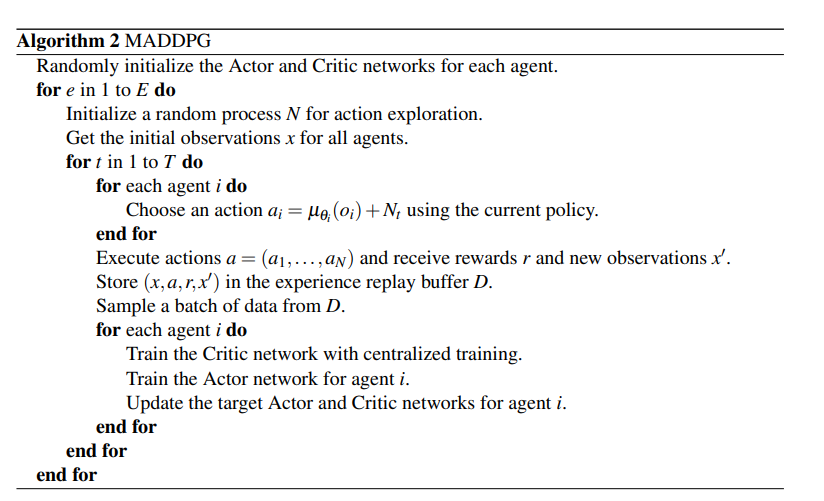

In [5]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import random
from tqdm import tqdm
import collections
#collections模块实现了特定目标的容器，以提供Python标准内建容器dict ,list , set , 和tuple的替代选择（deque

## Gumbel-Softmax采样
但是MPE环境中每个智能体的动作空间是离散的，可以使用Gumbel-Softmax来得到离散分布的近似采样。

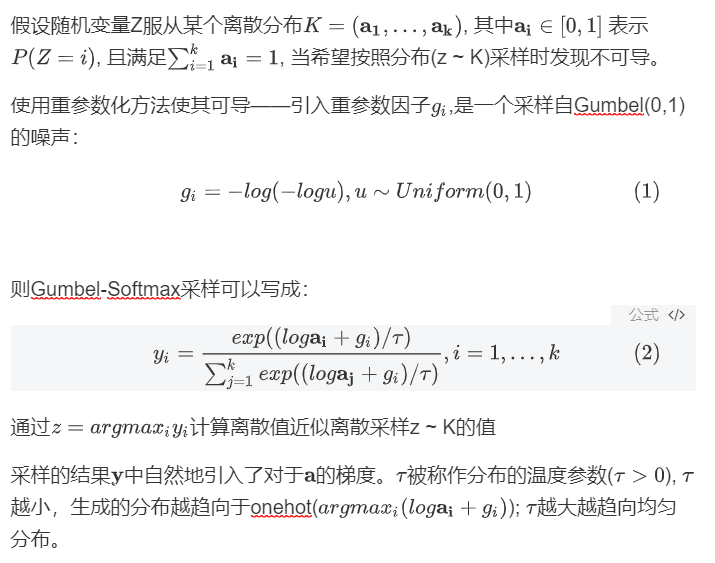

epsilon - greedy
深度挖掘 - exploitation
exploration
ai(little) + gi()
ai(big) + gi() -> 很接近1 + g -》 影响很大 
gi =》向中间集中 =》 onehot 
->一定随机性->exploration
生成2000 u， -log-log -》 histogram -》取值范围 -》noise范围

$\tau >=2$砍一半 小变大大变小


In [6]:
def onehot_from_logits(logits, eps=0.01):
    ''' 生成最优动作的独热（one-hot）形式（简称变成01）'''
    #print(logits)
    #logits = logits.view(1,-1)
    #argmax,对数概率中每行最大值所在位置
    #随机动作矩阵，转换成独热形式
    #rand_acs = torch.autograd.Variable( #具有自动求导功能的变量类型
    #    torch.eye(logits.shape[1])[ #张量列数-动作数量-单位矩阵-onehot编码
    argmax_acs = (logits == logits.max(-1, keepdim=True)[0]).float()
    rand_acs = torch.autograd.Variable( 
        torch.eye(logits.shape[-1])[ 
            [np.random.choice(range(logits.shape[-1]),
                              
             size = logits.shape[0])]],
            requires_grad=False).to(logits.device)
    if argmax_acs.shape != rand_acs.shape:
        print("logits:",logits.shape)
        print("arg:",argmax_acs.shape)
        print("rand:",rand_acs.shape)
    
    '''
    eye(act,act)
    eye[rand(0...act),batch]
    
    '''
    #        [np.random.choice(range(logits.shape[1]),
    #                          #随机选择的索引数组，长度与张量行数相同——选择多少个随机动作
    #         size = logits.shape[0])]],#创建随机onehot编码矩阵
    #        requires_grad=False).to(logits.device)
        #通过epsilon-greedy选择动作
        #生成一个[0,1)大小等同动作数量的张量
        #根据随机值r和阈值eps大小选择最优动作或随机动作
        #堆叠动作张量
    return torch.stack([argmax_acs[i] if r > eps else rand_acs[i] for i, r in enumerate(torch.rand(logits.shape[0]))])

In [7]:
def sample_gumbel(shape, eps=1e-20, tens_type=torch.FloatTensor):
    """从Gumbel(0,1)分布中采样"""
    #print("shape",shape,*shape)
    #U = torch.Tensor(tens_type(*shape).uniform_(),requires_grad=False)
    U = torch.autograd.Variable(tens_type(*shape).uniform_(), requires_grad=False)
    #[0,1)均匀分布填充指定形状shape的空白向量
    return -torch.log(-torch.log(U+eps)+eps)

In [8]:
def gumbel_softmax_sample(logits, temperature=1.0):
    """从Gumbel-Softmax分布中采样"""
    #(batch,actdim)
    y=logits+sample_gumbel(logits.shape, tens_type=type(logits.data)).to(logits.device)
    #print("y:",y)
    #print("logits.shape:",logits.shape)
    #y = y.unsqueeze(0)
    return F.softmax(y/temperature, dim=-1)   

In [9]:
def gumbel_softmax(logits, temperature=1.0):
    """GS采样并离散化"""
    #print("Shape of logits",logits.shape)
    #y = gumbel_softmax_sample(logits, temperature)
    #print("Shapes of y:", y.shape)
    #y_hard = onehot_from_logits(y)
    #print(y_hard.shape)
    #y = (y_hard.to(logits.device)-y).detach() +y
    try: 
        
        y = gumbel_softmax_sample(logits, temperature)
        y_hard = onehot_from_logits(y)

        y = (y_hard.to(logits.device)-y).detach() +y
        return y
    except Exception as e:
        print("Shapes of y:", y.shape)
        print("Shapes of y_hard:", y_hard.shape)
        print("Shapes of logits:", logits.shape)
        print(e)

    #返回一个y_hard的独热量。但是它的梯度是y---既能得到一个与环境交互的离散动作
    #又可以正确地反传梯度
    return y


## 单智能体DDPG(Actor网络与Critic网络)

In [10]:
class TwoLayerFC(torch.nn.Module):
    def __init__(self, num_in, num_out, hidden_dim):
        super().__init__()
        self.fc1 = torch.nn.Linear(num_in,hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = torch.nn.Linear(hidden_dim, num_out)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

In [11]:
class DDPG:
    def __init__(self, state_dim, action_dim, critic_input_dim, 
                 hidden_dim, actor_lr, critic_lr, device):
        self.actor = TwoLayerFC(state_dim, action_dim, hidden_dim).to(device)
        self.target_actor = TwoLayerFC(state_dim, action_dim,hidden_dim).to(device)
        self.critic = TwoLayerFC(critic_input_dim, 1, hidden_dim).to(device)
        self.target_critic = TwoLayerFC(critic_input_dim, 1, hidden_dim).to(device)
        self.target_critic.load_state_dict(self.critic.state_dict())
        self.target_actor.load_state_dict(self.actor.state_dict())
        #通过将另一个网络（通常称为本地网络）的参数复制到目标网络来实现参数的软更新
        #print("opt",self.actor.state_dict(), actor_lr)
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=actor_lr)
        
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(),lr=critic_lr)
        
    def take_action(self,state, explore=False):
        #print("state:",state)
        action = self.actor(state)
        #print("action:",action)
        if explore:
            action = gumbel_softmax(action.unsqueeze(0))
        else: 
            action = onehot_from_logits(action.unsqueeze(0))
        #使用 detach() 来生成一个不需要梯度的张量副本
        return action.detach().cpu().numpy()[0]
    
    def soft_update(self, net, target_net, tau):
        for param_target, param in zip(target_net.parameters(), net.parameters()):
            #将原始网络参数和目标网络参数按照比例进行加权平均，其中 tau 控制了更新的幅度。
            param_target.data.copy_(param_target.data*(1.0-tau)+param.data*tau)

## MADDPG
对于每个智能体维护一个DDPG

In [12]:
class MADDPG:
    def __init__(self, env, device, actor_lr, critic_lr, 
                 hidden_dim, state_dims, action_dims, critic_input_dim, gamma, tau):
        self.agents = []
        #print(len(env.agents),env.agents)
        for i in range(len(env.agents)):
            print("DDPG",state_dims[i], action_dims[i], 
                                    critic_input_dim, hidden_dim, actor_lr, 
                                    critic_lr, device)
            self.agents.append(DDPG(state_dims[i], action_dims[i], 
                                    critic_input_dim, hidden_dim, actor_lr, 
                                    critic_lr, device))
            #print("self.agents",self.agents)
        self.gamma = gamma
        self.tau = tau
        self.critic_criterion = torch.nn.MSELoss()#使用均方误差
        self.device = device
        
    @property #让方法像属性一样访问
    def policies(self):
        return [agt.actor for agt in self.agents]
    
    @property  
    def target_policies(self):
        return [agt.target_actor for agt in self.agents]
    
    def take_action(self, states, explore):
        #print("states",states)
        #states = [torch.tensor([states[i]], dtype=torch.float, device=self.device) 
        #          for i in range(len(env.agents))]
        cur_states = []
     
        #print(len(env.agents))
        #print(cur_states)
        try:
            for key, value in states.items():
                cur_states.append(value)
        #print("states.items",states.items())
            states = [torch.tensor(cur_states[i], dtype=torch.float32, device=self.device) for i, agent in enumerate(self.agents)]
        except Exception as e:
            print("states:",states)
            print("cur_state:",cur_states)
            print(e)
        #print("states",states)
        #print("self.agents:",self.agents)
        return [agent.take_action(state, explore) for agent, state in zip(self.agents, states)]
    '''
    def take_action(self, states, explore):
        return [agent.take_action(states[i], explore) for i, agent in enumerate(self.agents)]
    '''
    def update(self, obs, act, rew, next_obs, done, i_agent):#tuple,int
        #obs, act, rew, next_obs, done=sample
        #print("next_obs:",next_obs)
        #next_obs = torch.tensor(next_obs, dtype=torch.float32).to(device)
        cur_agent = self.agents[i_agent]
        cur_agent.critic_optimizer.zero_grad()#在进行反向传播之前，清除当前智能体的评价者（critic）优化器的梯度
        all_target_act = [onehot_from_logits(pi(_next_obs)) 
                          for pi, _next_obs in zip(self.target_policies, next_obs)]#pi--策略
        #print("Shapes of ata:", [t.shape for t in all_target_act])
        #all_target_act = [onehot_from_logits(pi(next_obs[i_agent])) for i_agent, pi in enumerate(self.target_policies)]
        #next_obs--下一观察状态 - tarActor(state_dim, action_dim)     Actor网络和obs对应(agent-state）
        #只能要 1 array的next_obs
        #onehot浮点转01
        #局部的state给Actor判断 action
        
        
        
        
        '''
        广播大坑
        两处view，不然加法也会广播
        
        cri_out = cur_agent.target_critic(target_critic_input)
       
        target_critic_value = rew[i_agent].view(-1,1) + self.gamma * cri_out.mul(1-done[i_agent].view(-1,1))

        print("Shapes of tar:", [t.shape for t in target_critic_value])
        print("Shapes of criout:", [t.shape for t in cri_out])

        '''
        
        
        
        
        
        
        
        
        #print("Shapes of next_obs:", [t.shape for t in next_obs])
        #print("Shapes of all_target_act:", [t.shape for t in all_target_act])
        
        target_critic_input = torch.cat((*next_obs, *all_target_act), dim=1)#列方向拼接--43
        #注意tuple
        
        #全局的43条state和action给 Critic 评价(value)
        
        #target_critic_value = rew[i_agent].view(-1,1) + self.gamma * cur_agent.target_critic(
        #    target_critic_input)*(1-done[i_agent].view(-1,1))
        #print("rew",rew)
        #print(rew[i_agent])
        target_critic_value = rew[i_agent].view(-1,1) + self.gamma * cur_agent.target_critic(
            target_critic_input).mul(1-done[i_agent].view(-1,1))

        #view改变张量Tensor形状，-1表示着这一维度大小自动计算
        #1d reward-> 2d Tensor (column vector)(n,1)  ...（n,)的形式容易爆
        #done 1d bool -> 1 - 0/1 -> 只在未完成时，考虑critic评估的全局未来价值

        
          
        #print("Shapes of obs:", [t.shape for t in obs])
          
        #print("Shapes of act:", [t.shape for t in act])
        critic_input = torch.cat((*obs, *act), dim=1)
 
        
        critic_value = cur_agent.critic(critic_input)
        critic_loss = self.critic_criterion(critic_value, target_critic_value.detach())
        #MSE均方误差求loss
        #detach()创建新张量（共享数据不具备梯度）防止（bp时）梯度回传，不受权重更新影响
        #tarCritic是critic的拷贝，更新速度慢(软更新),为计算期望的未来回报提供相对稳定的学习目标 + 防过拟合和震荡
        #解决自举问题（bootstrap）:当前的价值估计依赖于后续的价值估计。通过使用目标网络来生成这些后续的价值估计，可以减少估计中的偏差和方差
        
        
        
        critic_loss.backward()
        cur_agent.critic_optimizer.step()#更新critic权重
        
        cur_agent.actor_optimizer.zero_grad()
        cur_actor_out = cur_agent.actor(obs[i_agent])
        cur_act_vf_in = gumbel_softmax(cur_actor_out)#产生可导动作选择
        all_actor_acs = []
        for i, (pi, _obs) in enumerate(zip(self.policies, obs)):
            if i == i_agent:
                all_actor_acs.append(cur_act_vf_in)#可优化代码
                
            else:
                all_actor_acs.append(onehot_from_logits(pi(_obs)))
                
        #对于每个智能体，收集其在当前观察状态下各自Actor的动作。
        #value function
        
        #print("Shapes of obs:", [t.shape for t in obs])
        #print("Shapes of all_actor_acs:", [t.shape for t in all_actor_acs])
        vf_in = torch.cat((*obs, *all_actor_acs), dim=1)
        actor_loss = -cur_agent.critic(vf_in).mean()
        #从buffer随机采样了多组的sample，批训练
        #负号：最大化奖励（critic输出），梯度下降中最小化损失
        
        actor_loss += (cur_actor_out**2).mean()*1e-3
        #动作大小的平方和。可以视为动作的能量或强度
        #中心化（正则）动作价值函数 Q，2个连续的策略
        actor_loss.backward()
        cur_agent.actor_optimizer.step()
        
    def update_all_targets(self):
        for agt in self.agents:
            agt.soft_update(agt.actor, agt.target_actor, self.tau)
            agt.soft_update(agt.critic, agt.target_critic, self.tau)
                               

## 评估策略

In [13]:
def evaluate(env, maddpg, n_episode=10, episode_length=25):
    #evaluate, no explore
    returns = np.zeros(len(maddpg.agents))
    for _ in range(n_episode):
        obs, info = env.reset()
        for t_i in range(episode_length):
            actions = maddpg.take_action(obs, explore=False)
            #print("e_actions",actions)
            e_acts = {agent: np.argmax(action) for agent, action in zip(env.agents, actions)}
            obs, rew, done,trun, info = env.step(e_acts)
            rew_value = np.array(list(rew.values()),dtype=np.float64)
            returns += rew_value #累计每个代理的reward
    returns /= n_episode   #avg
    return returns.tolist()

## utils


In [14]:
class ReplayBuffer:#缓冲区存储每一步状态、动作、奖励、下一个状态和结束标志
    def __init__(self, capacity):
        self.buffer = collections.deque(maxlen = capacity)#queue
    
    def add(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))
        
    def sample(self, batch_size):#随机从缓冲区抽取
        transitions = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done=zip(*transitions)
        #print(action)
        return np.array(state), action, reward, np.array(next_state), done
    
    def size(self):
        return len(self.buffer)

In [15]:
def moving_average(a, window_size):
    cumulative_sum = np.cumsum(np.insert(a, 0, 0))#在a前面插入0并求累积和
    middle = (cumulative_sum[window_size:] - cumulative_sum[:-window_size])/window_size
    #前缀和-作差-滑动窗口-滑动平均-中间部分
    r = np.arange(1, window_size-1, 2)
    #开头和结尾窗口渐入渐出
    begin = np.cumsum(a[:window_size-1])[::2]/r
    end = (np.cumsum(a[:-window_size:-1])[::2]/r)[::-1]#注意end-0，end-1
    #variance不一样
    #总共2*((window_size-1)//2)+n-window_size+1个滑动平均值
    return np.concatenate((begin,middle,end))

## Training


In [17]:
env = simple_adversary_v3.parallel_env()
observations, infos = env.reset()
while env.agents:
    # this is where you would insert your policy
    actions = {agent: env.action_space(agent).sample() for agent in env.agents}
    #print(actions)
    observations, rewards, terminations, truncations, infos = env.step(actions)
env.close()

In [19]:
num_episodes = 100
episode_length = 96 #每条序列的最大长度
buffer_size = 100000
hidden_dim = 64
actor_lr = 1e-2
critic_lr = 1e-2
gamma = 0.95
tau = 1e-2
batch_size = 16
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
update_interval = 48
minimal_size = 4

cuda


In [21]:
replay_buffer = ReplayBuffer(buffer_size)

In [22]:
state_dims=[]
action_dims=[]

In [23]:
env.action_spaces

d:\Disk_D\programming_software\AI\Anaconda3\envs\pettingZoo_Langchain\lib\site-packages\pettingzoo\utils\conversions.py:158: UserWarning: The `action_spaces` dictionary is deprecated. Use the `action_space` function instead.
  warnings.warn(


{'adversary_0': Discrete(5), 'agent_0': Discrete(5), 'agent_1': Discrete(5)}

In [24]:
env.observation_spaces

d:\Disk_D\programming_software\AI\Anaconda3\envs\pettingZoo_Langchain\lib\site-packages\pettingzoo\utils\conversions.py:144: UserWarning: The `observation_spaces` dictionary is deprecated. Use the `observation_space` function instead.
  warnings.warn(


{'adversary_0': Box(-inf, inf, (8,), float32),
 'agent_0': Box(-inf, inf, (10,), float32),
 'agent_1': Box(-inf, inf, (10,), float32)}

In [25]:
env.reset()

({'adversary_0': array([-0.02643665, -1.4802644 ,  0.38826776, -0.14193895,  1.4645009 ,
          0.09775715, -0.49000794, -1.4132854 ], dtype=float32),
  'agent_0': array([-1.4909376 , -1.5780215 , -1.4909376 , -1.5780215 , -1.0762331 ,
         -0.2396961 , -1.4645009 , -0.09775715, -1.9545089 , -1.5110426 ],
        dtype=float32),
  'agent_1': array([ 0.46357128, -0.06697901,  0.46357128, -0.06697901,  0.8782757 ,
          1.2713464 ,  0.49000794,  1.4132854 ,  1.9545089 ,  1.5110426 ],
        dtype=float32)},
 {'adversary_0': {}, 'agent_0': {}, 'agent_1': {}})

In [26]:
for state_space in env.observation_spaces:
    print(state_space, type(state_space))

adversary_0 <class 'str'>
agent_0 <class 'str'>
agent_1 <class 'str'>


In [27]:
for action_space_key, action_space in env.action_spaces.items():
    action_dims.append(action_space.n)
for state_space_key, state_space in env.observation_spaces.items(): #observation_space != observation_spaces
    state_dims.append(state_space.shape[0])

In [28]:
state_dims

[8, 10, 10]

In [29]:
action_dims

[5, 5, 5]

In [30]:
critic_input_dim = sum(state_dims) +sum(action_dims)

In [39]:
maddpg = MADDPG(env, device, actor_lr, critic_lr, hidden_dim, state_dims, action_dims, critic_input_dim, gamma, tau)

DDPG 8 5 43 64 0.01 0.01 cuda
DDPG 10 5 43 64 0.01 0.01 cuda
DDPG 10 5 43 64 0.01 0.01 cuda


In [40]:
return_list = [] #记录每一轮的回报
total_step = 0

In [41]:
#for agent, action in env_actions.items():
#    print(agent,action)

Agent action space: [no_action, move_left, move_right, move_down, move_up]

Adversary action space: [no_action, move_left, move_right, move_down, move_up]

In [44]:
from pettingzoo.mpe import simple_adversary_v3

#env = simple_adversary_v3.env(render_mode="human")
env = simple_adversary_v3.parallel_env(max_cycles=96)
#`"human"`，启用`pygame`窗口的可视化
#pygame可视化会严重拖慢训练
agents = ['adversary_0', 'agent_0', 'agent_1']


for i_episode in range(num_episodes):   #执行多次游戏
    state, info = env.reset(seed = 42)   #重置环境并开始新的游戏轮次并获取初始状态
    
    #print("state:",state)
    # ep_returns = np.zeros(len(env.agents))
    for e_i in range(episode_length):     #游戏轮次内的操作次数
        #print(state)
        #print(e_i)
        actions = maddpg.take_action(state, explore=True)#注意修改softmax此处会变
        #print(actions)
        env_actions = {agent: np.argmax(action) for agent, action in zip(agents, actions)}
        #print(env_actions)
        #检查动作是否符合动作空间
        #for agent, action in env_actions.items():
            #assert env.action_space(agent).contains(action), f"Action {action} is not in action space for agent {agent}"

        
        next_state, reward, done, truncations, infos = env.step(env_actions)
        #observations, rewards, terminations, truncations, infos = env.step(actions)
        #print(actions)
        #print("done:",done)
        replay_buffer.add(state, actions, reward, next_state, done)
        state = next_state
        #print("state",state)
        total_step += 1
        #隔一定步数进行训练
        #检查缓冲区是否有足够样本数
        if replay_buffer.size() >= minimal_size and total_step % update_interval == 0:
            #print("stateif",state)
            obs, act, rew, next_obs, done = replay_buffer.sample(batch_size)#抽样 tuple(np.array(state), action, reward, np.array(next_state), done)
            #print(state)
            #len(sample[0]) == batch_size
            #for sub_x in sample:
            #    print(type(sub_x))
            #    for i in range(batch_size):
            #        print("sub_x[i]:",sub_x[i])
            #print(sample)
            #def stack_array(x):
            #    rearranged = []
            #    for sub_x in x:
            #        if isinstance(sub_x, dict):
                        # 将字典中的值（每个智能体的观察数据）转换为张量
            #            items = [torch.tensor(v, dtype=torch.float32).to(device) for v in sub_x.values()]
            #            rearranged.extend(items)  # 使用 extend 而不是 append
            #        elif isinstance(sub_x, list) or isinstance(sub_x, defaultdict):
                        # 对于列表和defaultdict类型的数据（如动作、奖励和完成标志），直接转换为张量
            #            item = torch.tensor(sub_x, dtype=torch.float32).to(device)
            #            rearranged.append(item)
            #        else:
            #            item = torch.tensor(sub_x, dtype=torch.float32).to(device)
            #            rearranged.append(item)

            #    return rearranged
            
           
            obs_list, act_list, rew_list, next_obs_list, done_list = [], [], [], [], []

            #for s, a, reward_dicts, next_state_dicts, done_dicts in :
                #print(a)
            for i, agent in enumerate(['adversary_0', 'agent_0', 'agent_1']):
                obs_list.append(np.array([s[agent] for s in obs]))
                act_list.append(np.array([a[i] for a in act]))
                rew_list.append(np.array([r[agent] for r in rew]))
                next_obs_list.append(np.array([ns[agent] for ns in next_obs]))
                done_list.append(np.array([d[agent] for d in done]))

            obs_tensor = [torch.tensor(o, dtype=torch.float32).to(device) for o in obs_list]
            act_tensor = [torch.tensor(a, dtype=torch.float32).to(device) for a in act_list]
            rew_tensor = [torch.tensor(r, dtype=torch.float32).to(device) for r in rew_list]                 
            next_obs_tensor = [torch.tensor(n, dtype=torch.float32).to(device) for n in next_obs_list]
            done_tensor = [torch.tensor(d, dtype=torch.float32).to(device) for d in done_list]  # 将布尔类型转换为浮点数类型

            #sample = [stack_array(x) for x in sample]
            #[print(type(subs)) for subs in sample]
            #print(state)
            for a_i in range(len(env.agents)):
                maddpg.update(obs_tensor,act_tensor,rew_tensor,next_obs_tensor,done_tensor, a_i)#(要素，agent编号) #感觉可以改成一次传参优化速度
            maddpg.update_all_targets()
        #隔一定轮次评估性能
        #if (i_episode+1) % 100 == 0 :
    ep_returns = evaluate(env, maddpg, n_episode=100)
    return_list.append(ep_returns)
            #print("state:", next_state)
    print("actions:", env_actions)
    print(f"Episode: {i_episode+1}, {ep_returns}")
            
env.close()

actions: {'adversary_0': 2, 'agent_0': 3, 'agent_1': 2}
Episode: 1, [-51.53556224129231, 9.357263363338616, 9.357263363338616]
actions: {'adversary_0': 2, 'agent_0': 2, 'agent_1': 2}
Episode: 2, [-45.55709653674469, -0.45215907822933765, -0.45215907822933765]
actions: {'adversary_0': 4, 'agent_0': 4, 'agent_1': 3}
Episode: 3, [-42.01235039201516, -4.066111193234498, -4.066111193234498]
actions: {'adversary_0': 3, 'agent_0': 4, 'agent_1': 2}
Episode: 4, [-37.532894640147894, -8.293421933412363, -8.293421933412363]
actions: {'adversary_0': 0, 'agent_0': 4, 'agent_1': 3}
Episode: 5, [-34.67731963857621, -5.502549833592099, -5.502549833592099]
actions: {'adversary_0': 3, 'agent_0': 4, 'agent_1': 3}
Episode: 6, [-36.70528777783154, -3.133731661585677, -3.133731661585677]
actions: {'adversary_0': 3, 'agent_0': 4, 'agent_1': 3}
Episode: 7, [-33.31167515956435, -7.726951773940389, -7.726951773940389]
actions: {'adversary_0': 0, 'agent_0': 4, 'agent_1': 3}
Episode: 8, [-26.790540767116134, -15.

## Testing


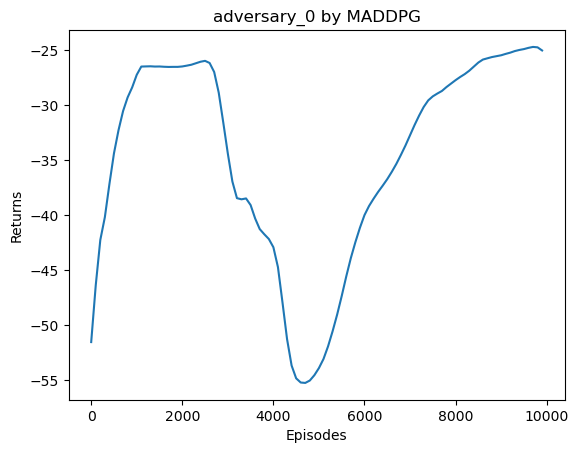

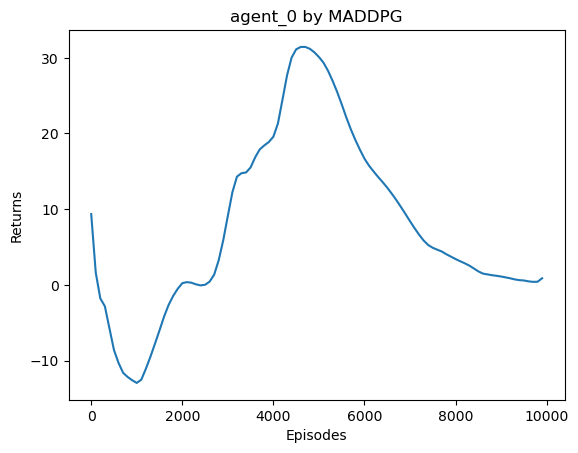

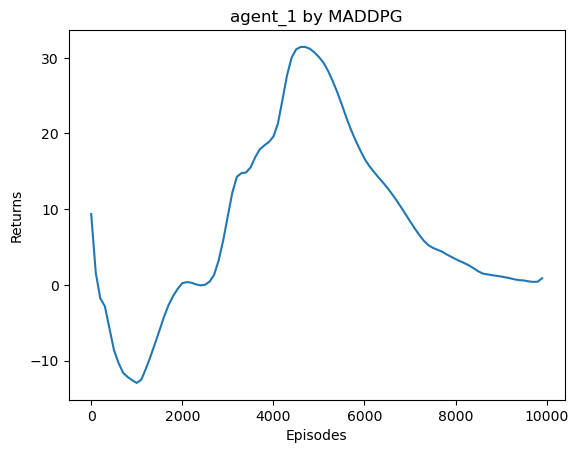

In [45]:
return_array = np.array(return_list)
for i, agent_name in enumerate(["adversary_0","agent_0","agent_1"]):
    plt.figure()
    plt.plot(np.arange(return_array.shape[0])*100, moving_average(return_array[:,i],9))
    plt.xlabel("Episodes")
    plt.ylabel("Returns")
    plt.title(f"{agent_name} by MADDPG")

In [48]:
from datetime import datetime
import os
current_time = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
# 构建模型文件名
model_name = f'{current_time}.pth'

# 确保保存模型的目录存在
actor_save_dir = f'saved_models/maddpg/{current_time}/actor'
critic_save_dir = f'saved_models/maddpg/{current_time}/critic'
os.makedirs(actor_save_dir, exist_ok=True)
os.makedirs(critic_save_dir, exist_ok=True)

for i, ddpgs in enumerate(maddpg.agents):
    
    torch.save(ddpgs.actor.state_dict(), os.path.join(actor_save_dir,f'actor_{i}_{model_name}'))
    torch.save(ddpgs.critic.state_dict(), os.path.join(critic_save_dir,f'critic_{i}_{model_name}'))
    # 打印保存的模型文件名
    print(f"Model parameters saved as '{model_name}'")

Model parameters saved as '2024-03-21_20-01-13.pth'
Model parameters saved as '2024-03-21_20-01-13.pth'
Model parameters saved as '2024-03-21_20-01-13.pth'


In [32]:
def load_params(params, path):
    for filename in os.listdir(path):
        if filename.endswith('.pth'):
            params.append(torch.load(os.path.join(path,filename)))
    
    return params

In [38]:
import torch
import os
params_date = '2024-03-31_21-54-20'
actor_params_dir = f'./parameters/weights/sa_maddpg/{params_date}/actor'

critic_params_dir = f'./parameters/weights/sa_maddpg/{params_date}/critic'

actor_params = []
critic_params = []

actor_params = load_params(actor_params,actor_params_dir)
critic_params = load_params(critic_params, critic_params_dir)

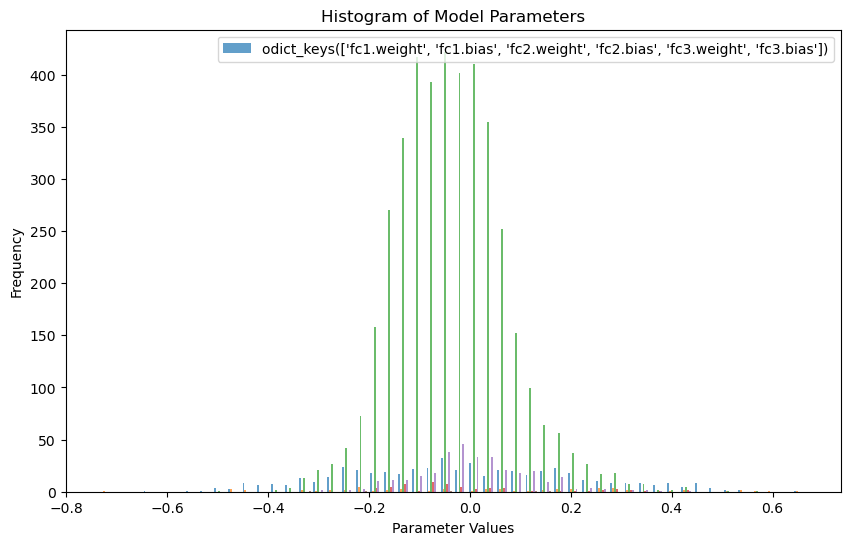

In [10]:
import matplotlib.pyplot as plt
# 参数可视化分析

params = actor_params[0]
# 将参数转换为 NumPy 数组
params_array = []
for param_name, param_value in params.items():
    params_array.append(param_value.cpu().numpy().flatten())

# 绘制直方图
plt.figure(figsize=(10, 6))
plt.hist(params_array, bins=50, alpha=0.7, label=params.keys())
plt.legend()
plt.xlabel('Parameter Values')
plt.ylabel('Frequency')
plt.title('Histogram of Model Parameters')
plt.show()

In [39]:
#加载参数
maddpg = MADDPG(env, device, actor_lr, critic_lr, hidden_dim, state_dims, action_dims, critic_input_dim, gamma, tau)


for i, ddpgs in enumerate(maddpg.agents):
    
    # 加载保存的模型参数
    ddpgs.actor.load_state_dict(actor_params[i])
    ddpgs.critic.load_state_dict(critic_params[i])
    
    #设置为评估模式
    ddpgs.actor.eval()
    ddpgs.critic.eval()

DDPG 8 5 43 64 0.01 0.01 cuda
DDPG 10 5 43 64 0.01 0.01 cuda
DDPG 10 5 43 64 0.01 0.01 cuda


In [41]:
from pettingzoo.mpe import simple_adversary_v3


env = simple_adversary_v3.env(render_mode="human")
max_cycle=200
test_env = simple_adversary_v3.parallel_env(max_cycles=max_cycle)
#`"human"`，启用`pygame`窗口的可视化
#pygame可视化会严重拖慢训练
test_agents = ['adversary_0', 'agent_0', 'agent_1']


test_state, info = test_env.reset(seed = 42)   #重置环境并开始新的游戏轮次并获取初始状态
    
print("state_0:",test_state)
print("info:", info)
    # ep_returns = np.zeros(len(env.agents))

        #print(state)
    
    
    #print(e_i)
cur_state = test_state    
last_actions={"adversary_0": -1, "agent_0": -1, "agent_1": -1}    
for i in range(max_cycle):
    
    test_actions = maddpg.take_action(cur_state, explore=False)#注意修改softmax此处会变
    

    #print("actions_{i}:",test_actions)
    #print(actions)

    
    test_env_actions = {t_agent: np.argmax(t_action) for t_agent, t_action in zip(test_agents, test_actions)}
    if test_env_actions == last_actions and i!=max_cycle-1:
        continue
    print(f"state_{i}: {cur_state}")   
    print(f"action_{i}: {test_env_actions}")
    #print(f"state_{i}: {env.state}")
    
    t_next_state, t_reward, t_done, t_truncations, t_infos = test_env.step(test_env_actions)
    print(f"reward_{i}: {t_reward}")
    print(f"state_{i+1}: {t_next_state}")

    cur_state = t_next_state
    last_actions = test_env_actions
    if t_reward == {}:
        print('done:',t_done)
        print('truncations:',t_truncations)
        break
    #print("t_done:",t_done)

state_0: {'adversary_0': array([ 0.69437176, -1.4609686 ,  0.023015  , -0.97559977,  0.51697916,
       -1.5288411 ,  1.0734879 , -0.19491644], dtype=float32), 'agent_0': array([ 0.17739256,  0.06787257,  0.17739256,  0.06787257, -0.4939642 ,
        0.5532414 , -0.51697916,  1.5288411 ,  0.55650866,  1.3339247 ],
      dtype=float32), 'agent_1': array([-0.3791161 , -1.2660521 , -0.3791161 , -1.2660521 , -1.0504729 ,
       -0.78068334, -1.0734879 ,  0.19491644, -0.55650866, -1.3339247 ],
      dtype=float32)}
info: {'adversary_0': {}, 'agent_0': {}, 'agent_1': {}}
state_0: {'adversary_0': array([ 0.69437176, -1.4609686 ,  0.023015  , -0.97559977,  0.51697916,
       -1.5288411 ,  1.0734879 , -0.19491644], dtype=float32), 'agent_0': array([ 0.17739256,  0.06787257,  0.17739256,  0.06787257, -0.4939642 ,
        0.5532414 , -0.51697916,  1.5288411 ,  0.55650866,  1.3339247 ],
      dtype=float32), 'agent_1': array([-0.3791161 , -1.2660521 , -0.3791161 , -1.2660521 , -1.0504729 ,
       

In [75]:
from pettingzoo.mpe import simple_adversary_v3


env = simple_adversary_v3.env(render_mode="human")
max_cycle=200
test_env = simple_adversary_v3.parallel_env(max_cycles=max_cycle)
#`"human"`，启用`pygame`窗口的可视化
#pygame可视化会严重拖慢训练
test_agents = ['adversary_0', 'agent_0', 'agent_1']


test_state, info = test_env.reset(seed = 42)   #重置环境并开始新的游戏轮次并获取初始状态
    
print("state_0:",test_state)
print("info:", info)
    # ep_returns = np.zeros(len(env.agents))

        #print(state)
    
    
    #print(e_i)
cur_state = test_state    
last_actions={"adversary_0": -1, "agent_0": -1, "agent_1": -1}    
for i in range(max_cycle):
    
    test_actions = maddpg.take_action(cur_state, explore=False)#注意修改softmax此处会变
    

    #print("actions_{i}:",test_actions)
    #print(actions)

    
    test_env_actions = {t_agent: np.argmax(t_action) for t_agent, t_action in zip(test_agents, test_actions)}
    if test_env_actions == last_actions and i!=max_cycle-1:
        continue
    print(f"state_{i}: {cur_state}")   
    print(f"action_{i}: {test_env_actions}")
    #print(f"state_{i}: {env.state}")
    
    t_next_state, t_reward, t_done, t_truncations, t_infos = test_env.step(test_env_actions)
    print(f"reward_{i}: {t_reward}")
    print(f"state_{i+1}: {t_next_state}")

    cur_state = t_next_state
    last_actions = test_env_actions
    if t_reward == {}:
        print('done:',t_done)
        print('truncations:',t_truncations)
        break
    #print("t_done:",t_done)

state_0: {'adversary_0': array([-1.0825291 ,  0.81086814, -1.8458092 ,  1.218707  , -0.0036285 ,
        0.3353437 , -1.0542744 ,  1.3670859 ], dtype=float32), 'agent_0': array([-1.0789006,  0.4755245, -1.0789006,  0.4755245, -1.8421806,
        0.8833633,  0.0036285, -0.3353437, -1.050646 ,  1.0317423],
      dtype=float32), 'agent_1': array([-0.02825462, -0.5562178 , -0.02825462, -0.5562178 , -0.79153466,
       -0.14837897,  1.0542744 , -1.3670859 ,  1.050646  , -1.0317423 ],
      dtype=float32)}
info: {'adversary_0': {}, 'agent_0': {}, 'agent_1': {}}
state_0: {'adversary_0': array([-1.0825291 ,  0.81086814, -1.8458092 ,  1.218707  , -0.0036285 ,
        0.3353437 , -1.0542744 ,  1.3670859 ], dtype=float32), 'agent_0': array([-1.0789006,  0.4755245, -1.0789006,  0.4755245, -1.8421806,
        0.8833633,  0.0036285, -0.3353437, -1.050646 ,  1.0317423],
      dtype=float32), 'agent_1': array([-0.02825462, -0.5562178 , -0.02825462, -0.5562178 , -0.79153466,
       -0.14837897,  1.0542

In [46]:
from pettingzoo.mpe import simple_adversary_v3
import json

#env = simple_adversary_v3.env(render_mode="human")
max_cycle=200
test_env = simple_adversary_v3.parallel_env(max_cycles=max_cycle)
#`"human"`，启用`pygame`窗口的可视化
#pygame可视化会严重拖慢训练
test_agents = ['adversary_0', 'agent_0', 'agent_1']


test_state, info = test_env.reset()   #重置环境并开始新的游戏轮次并获取初始状态
    
#print("state_0:",test_state)
#print("info:", info)
    # ep_returns = np.zeros(len(env.agents))

        #print(state)
    
    
    #print(e_i)
record_dict = {}    
    
cur_state = test_state    
last_actions={"adversary_0": -1, "agent_0": -1, "agent_1": -1}    
for i in range(max_cycle):
    
    test_actions = maddpg.take_action(cur_state, explore=False)#注意修改softmax此处会变
    

    #print("actions_{i}:",test_actions)
    #print(actions)

    
    test_env_actions = {t_agent: np.argmax(t_action) for t_agent, t_action in zip(test_agents, test_actions)}
    if test_env_actions == last_actions and i!=max_cycle-1:
        continue

    
    t_next_state, t_reward, t_done, t_truncations, t_infos = test_env.step(test_env_actions)

    

    
    round_data = {
        f"state_{i}": cur_state,
        f"actions_{i}": test_env_actions,
        f"reward_{i}": t_reward,
        f"state_{i+1}": t_next_state
    }
    
    record_dict[str(i)] = round_data
    

    cur_state = t_next_state
    last_actions = test_env_actions
    if t_reward == {}:
        print('done:',t_done)
        print('truncations:',t_truncations)
        break
    #print("t_done:",t_done)

In [58]:
def convert_ndarray(data):
    if isinstance(data, dict):
        return {key: convert_ndarray(value) for key, value in data.items()}
    elif isinstance(data, list):
        return [convert_ndarray(item) for item in data]
    elif isinstance(data, np.ndarray):
        return data.tolist()
    elif isinstance(data, np.integer):
        return int(data)
    else: 
        return data

In [59]:
def generate_filename(directory, base_filename):
    
    #生成新数据名
    files = os.listdir(directory)
    relevant_files = [f for f in files if f.startswith(base_filename) and f.endswith('.json')]
    next_num = len(relevant_files) + 1
    new_filename = f"{base_filename}_{next_num:06d}"
    return  os.path.join(directory, new_filename)
                      

In [62]:
dialogues_and_order = {
    "adversary_0(Thief)": {"dialogues": [[] for _ in range(4)]},
    "agent_0(Elf Wizard)": {"dialogues": [[] for _ in range(4)]},
    "agent_1(Human Warrior)": {"dialogues": [[] for _ in range(4)]},
    "order": [[] for _ in range(4)]
}


In [63]:
for round_key in record_dict.keys():
    record_dict[round_key].update(dialogues_and_order)

In [64]:
record_dict_cov = convert_ndarray(record_dict)

In [65]:
directory = './datasets/SFSA/SFSA_0200/'
base_filename =  'SFSA_0200'

filename = generate_filename(directory, base_filename)


with open(filename, 'w') as json_file:
    json.dump(record_dict_cov, json_file, indent=2)

## 基本网络连接思路
env -> DRPGA -> Action & NLP

env -> MADDPG -> action

按比例合成env-reward和LLM-reward

但是可能还需要在前面再加一个生成式模型，来量化env

需要的下一步工作：actor网络增加生成式网络， 用中心LLM知识蒸馏训练生成式网络，方式是prompt给出环境state和相关信息和网络层信息，map到LLM生成的策略和nlp


LLM -> Pair(env,nlp)--QA
prompt，QA标准，
QA -> miniGPT -> QA
reward <- LLM+env


In [32]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = collections.deque(maxlen = capacity)#queue
    
    def add(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))
        
    def sample(self, batch_size):
        transitions = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done=zip(*transitions)
        return np.array(state), action, reward, np.array(next_state), done
    
    def size(self):
        return len(self.buffer)
    

In [33]:
def moving_average(a, window_size):
    cumulative_sum = np.cumsum(np.insert(a, 0, 0))#在a前面插入0并求累积和
    middle = (cumulative_sum[window_size:] - cumulative_sum[:-window_size])/window_size
    #前缀和-作差-滑动窗口-滑动平均-中间部分
    r = np.arange(1, window_size-1, 2)
    #开头和结尾窗口渐入渐出
    begin = np.cumsum(a[:window_size-1])[::2]/r
    end = (np.cumsum(a[:-window_size:-1])[::2]/r)[::-1]#注意end-0，end-1
    #总共2*((window_size-1)//2)+n-window_size+1个滑动平均值
    return np.concatenate((begin,middle,end))

In [34]:
def train_on_policy_agent(

SyntaxError: unexpected EOF while parsing (3935028866.py, line 1)

In [ ]:
for i in range(400):
    for j in range(400):
        a = i*j
        b = i+j
        c = i/(j+1)
        d = i-j
        e = a+b+c+d
        for k in range(8):
            e += 2**k
print(e)

# IPPO
# ma_gym库的Combat环境：二维格子两队对战

动作集合：向四周移动一格，攻击周围3\*3格内其他敌对智能体，不采取动作

起初每个智能体3点生命值，被攻击扣1，至0死亡，攻击有一轮冷却时间

training：敌对队伍算法固定

与博弈论处理方式区别：存在必胜态和必败态，双方不一定必定选择最优决策。博弈论去分析切比雪夫距离在多少是必胜态来制定最有决策，而强化学习直接学习决策方式


In [ ]:
import torch
import torch.nn.functional as F
import numpy as np

In [ ]:
from tqdm import tqdm
import numpy as np
import torch
import collections
import random
import matplotlib.pyplot as plt

In [ ]:
import gymnasium as gym

In [ ]:
#同paddle静态库操作，方便扔上去训练
#import sys
#sys.path.append("./ma-gym")
#from ma_gym.envs.combat.combat import Combat

In [ ]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = collections.deque(maxlen=capacity) 

    def add(self, state, action, reward, next_state, done): 
        self.buffer.append((state, action, reward, next_state, done)) 

    def sample(self, batch_size): 
        transitions = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = zip(*transitions)
        return np.array(state), action, reward, np.array(next_state), done 

    def size(self): 
        return len(self.buffer)

def moving_average(a, window_size):
    cumulative_sum = np.cumsum(np.insert(a, 0, 0)) 
    middle = (cumulative_sum[window_size:] - cumulative_sum[:-window_size]) / window_size
    r = np.arange(1, window_size-1, 2)
    begin = np.cumsum(a[:window_size-1])[::2] / r
    end = (np.cumsum(a[:-window_size:-1])[::2] / r)[::-1]
    return np.concatenate((begin, middle, end))

def train_on_policy_agent(env, agent, num_episodes):
    return_list = []
    for i in range(10):
        with tqdm(total=int(num_episodes/10), desc='Iteration %d' % i) as pbar:
            for i_episode in range(int(num_episodes/10)):
                episode_return = 0
                transition_dict = {'states': [], 'actions': [], 'next_states': [], 'rewards': [], 'dones': []}
                state = env.reset()
                done = False
                while not done:
                    action = agent.take_action(state)
                    next_state, reward, done, _ = env.step(action)
                    transition_dict['states'].append(state)
                    transition_dict['actions'].append(action)
                    transition_dict['next_states'].append(next_state)
                    transition_dict['rewards'].append(reward)
                    transition_dict['dones'].append(done)
                    state = next_state
                    episode_return += reward
                return_list.append(episode_return)
                agent.update(transition_dict)
                if (i_episode+1) % 10 == 0:
                    pbar.set_postfix({'episode': '%d' % (num_episodes/10 * i + i_episode+1), 'return': '%.3f' % np.mean(return_list[-10:])})
                pbar.update(1)
    return return_list

def train_off_policy_agent(env, agent, num_episodes, replay_buffer, minimal_size, batch_size):
    return_list = []
    for i in range(10):
        with tqdm(total=int(num_episodes/10), desc='Iteration %d' % i) as pbar:
            for i_episode in range(int(num_episodes/10)):
                episode_return = 0
                state = env.reset()
                done = False
                while not done:
                    action = agent.take_action(state)
                    next_state, reward, done, _ = env.step(action)
                    replay_buffer.add(state, action, reward, next_state, done)
                    state = next_state
                    episode_return += reward
                    if replay_buffer.size() > minimal_size:
                        b_s, b_a, b_r, b_ns, b_d = replay_buffer.sample(batch_size)
                        transition_dict = {'states': b_s, 'actions': b_a, 'next_states': b_ns, 'rewards': b_r, 'dones': b_d}
                        agent.update(transition_dict)
                return_list.append(episode_return)
                if (i_episode+1) % 10 == 0:
                    pbar.set_postfix({'episode': '%d' % (num_episodes/10 * i + i_episode+1), 'return': '%.3f' % np.mean(return_list[-10:])})
                pbar.update(1)
    return return_list


def compute_advantage(gamma, lmbda, td_delta):
    td_delta = td_delta.detach().numpy()
    advantage_list = []
    advantage = 0.0
    for delta in td_delta[::-1]:
        advantage = gamma * lmbda * advantage + delta
        advantage_list.append(advantage)
    advantage_list.reverse()
    return torch.tensor(advantage_list, dtype=torch.float)


In [ ]:
class PolicyNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(PolicyNet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = torch.nn.Linear(hidden_dim, action_dim)
        
    def forward(self, x):
        x = F.relu(self.fc2(F.relu(self.fc1(x))))
        return F.softmax(self.fc3(x),dim=1)
    

class ValueNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim):
        super(ValueNet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = torch.nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = F.relu(self.fc2(F.relu(self.fc1(x))))
        return self.fc3(x)

In [ ]:
#截断PPO
class PPO:
    ''' PPO算法,采用截断方式 '''
    def __init__(self, state_dim, hidden_dim, action_dim, actor_lr, critic_lr,
                 lmbda, eps, gamma, device):
        self.actor = PolicyNet(state_dim, hidden_dim, action_dim).to(device)
        self.critic = ValueNet(state_dim, hidden_dim).to(device)
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(),
                                                lr=actor_lr)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(),
                                                 lr=critic_lr)
        self.gamma = gamma
        self.lmbda = lmbda
        self.eps = eps  # PPO中截断范围的参数
        self.device = device

    def take_action(self, state):
        state = torch.tensor([state], dtype=torch.float).to(self.device)
        probs = self.actor(state)
        action_dist = torch.distributions.Categorical(probs)
        action = action_dist.sample()
        return action.item()

    def update(self, transition_dict):
        states = torch.tensor(transition_dict['states'],
                              dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions']).view(-1, 1).to(
            self.device)
        rewards = torch.tensor(transition_dict['rewards'],
                               dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'],
                                   dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'],
                             dtype=torch.float).view(-1, 1).to(self.device)
        td_target = rewards + self.gamma * self.critic(next_states) * (1 -
                                                                       dones)
        td_delta = td_target - self.critic(states)
        advantage = rl_utils.compute_advantage(self.gamma, self.lmbda,
                                               td_delta.cpu()).to(self.device)
        old_log_probs = torch.log(self.actor(states).gather(1,
                                                            actions)).detach()

        log_probs = torch.log(self.actor(states).gather(1, actions))
        ratio = torch.exp(log_probs - old_log_probs)
        surr1 = ratio * advantage
        surr2 = torch.clamp(ratio, 1 - self.eps,
                            1 + self.eps) * advantage  # 截断
        actor_loss = torch.mean(-torch.min(surr1, surr2))  # PPO损失函数
        critic_loss = torch.mean(
            F.mse_loss(self.critic(states), td_target.detach()))
        self.actor_optimizer.zero_grad()
        self.critic_optimizer.zero_grad()
        actor_loss.backward()
        critic_loss.backward()
        self.actor_optimizer.step()
        self.critic_optimizer.step()

In [ ]:
actor_lr = 3e-4
critic_lr = 1e-3
num_episodes = 100000
hidden_dim = 64
gamma = 0.99
lmbda = 0.97
eps = 0.2
device = torch.device("cuda") if torch.cuda.is_available() else torch.device(
    "cpu")

team_size = 2
grid_size = (15, 15)
#创建Combat环境，格子世界的大小为15x15，己方智能体和敌方智能体数量都为2
env = Combat(grid_shape=grid_size, n_agents=team_size, n_opponents=team_size)

state_dim = env.observation_space[0].shape[0]
action_dim = env.action_space[0].n
#两个智能体共享同一个策略
agent = PPO(state_dim, hidden_dim, action_dim, actor_lr, critic_lr, lmbda, eps,
            gamma, device)

win_list = []
for i in range(10):
    with tqdm(total=int(num_episodes / 10), desc='Iteration %d' % i) as pbar:
        for i_episode in range(int(num_episodes / 10)):
            transition_dict_1 = {
                'states': [],
                'actions': [],
                'next_states': [],
                'rewards': [],
                'dones': []
            }
            transition_dict_2 = {
                'states': [],
                'actions': [],
                'next_states': [],
                'rewards': [],
                'dones': []
            }
            s = env.reset()
            terminal = False
            while not terminal:
                a_1 = agent.take_action(s[0])
                a_2 = agent.take_action(s[1])
                next_s, r, done, info = env.step([a_1, a_2])
                transition_dict_1['states'].append(s[0])
                transition_dict_1['actions'].append(a_1)
                transition_dict_1['next_states'].append(next_s[0])
                transition_dict_1['rewards'].append(
                    r[0] + 100 if info['win'] else r[0] - 0.1)
                transition_dict_1['dones'].append(False)
                transition_dict_2['states'].append(s[1])
                transition_dict_2['actions'].append(a_2)
                transition_dict_2['next_states'].append(next_s[1])
                transition_dict_2['rewards'].append(
                    r[1] + 100 if info['win'] else r[1] - 0.1)
                transition_dict_2['dones'].append(False)
                s = next_s
                terminal = all(done)
            win_list.append(1 if info["win"] else 0)
            agent.update(transition_dict_1)
            agent.update(transition_dict_2)
            if (i_episode + 1) % 100 == 0:
                pbar.set_postfix({
                    'episode':
                    '%d' % (num_episodes / 10 * i + i_episode + 1),
                    'return':
                    '%.3f' % np.mean(win_list[-100:])
                })
            pbar.update(1)


In [ ]:


win_array = np.array(win_list)
#每100条轨迹取一次平均
win_array = np.mean(win_array.reshape(-1, 100), axis=1)

episodes_list = np.arange(win_array.shape[0]) * 100
plt.plot(episodes_list, win_array)
plt.xlabel('Episodes')
plt.ylabel('Win rate')
plt.title('IPPO on Combat')
plt.show()



In [ ]:
conda  env list

In [ ]:
import subprocess

# 定义函数获取库列表
def get_library_list():
    # 使用 subprocess 运行 conda list 命令，并捕获输出
    result = subprocess.run(['conda', 'list'], capture_output=True, text=True)
    # 分割输出的行并丢弃头部信息
    lines = result.stdout.strip().split('\n')[4:]
    # 解析每行并输出库名称和版本号
    for line in lines:
        parts = line.strip().split()
        name = parts[0]
        version = parts[1]
        print(f"{name}=={version}")

# 调用函数打印库列表
get_library_list()


In [ ]:

import torch.nn.functional as F
import numpy as np
import matplotlib as plt
import random
import tqdm
import collections
import pettingzoo
import pygame

def print_library_versions():
    print("torch==", torch.__version__)
    print("numpy==", np.__version__)
    print("matplotlib==", plt.__version__)
    print("tqdm==", tqdm.__version__)
    print("pettingzoo==", pettingzoo.__version__)
    print("pygame==", pygame.__version__)
print_library_versions()

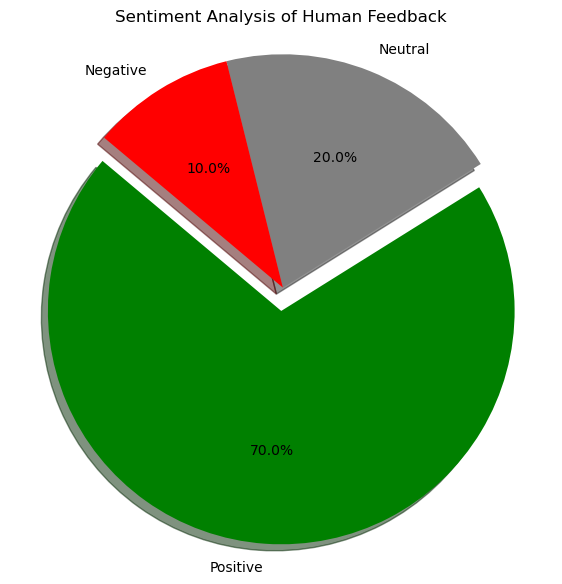

In [2]:
import matplotlib.pyplot as plt

# Define the data for the pie chart
labels = ['Positive', 'Neutral', 'Negative']
sizes = [70, 20, 10]  # Corresponding percentages
colors = ['green', 'gray', 'red']  # Assign colors to each sentiment
explode = (0.1, 0, 0)  # 'explode' the 1st slice (i.e., 'Positive')

# Create the pie chart
plt.figure(figsize=(7, 7))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.title('Sentiment Analysis of Human Feedback')
plt.axis('equal')  # Equal aspect ratio ensures the pie chart is circular.

# Save the chart as a PNG file
plt.savefig('sentiment_analysis_chart.png', format='png', dpi=300)

# Display the chart
plt.show()



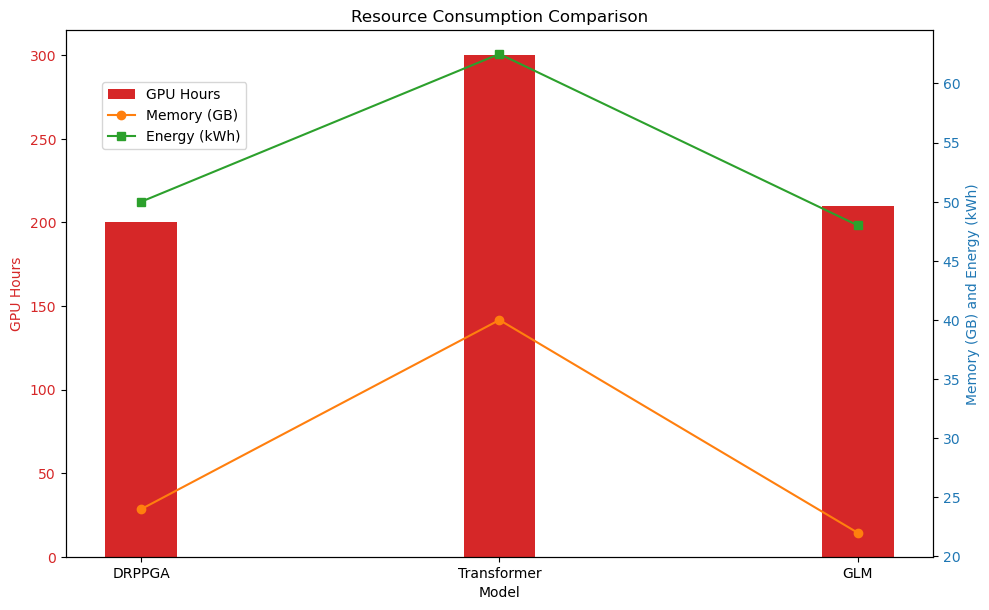

In [4]:
# Data for plotting
models = ['DRPPGA', 'Transformer', 'GLM']
gpu_hours = [200, 300, 210]
memory_gb = [24, 40, 22]
energy_kwh = [50, 62.5, 48]

x = range(len(models))  # the label locations

fig, ax1 = plt.subplots(figsize=(10, 6))

# Instantiate the first y-axis
color = 'tab:red'
ax1.set_xlabel('Model')
ax1.set_ylabel('GPU Hours', color=color)
ax1.bar(x, gpu_hours, color=color, width=0.2, label='GPU Hours')
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_xticks(x)
ax1.set_xticklabels(models)

# Instantiate a second y-axis that shares the same x-axis
ax2 = ax1.twinx()  
color = 'tab:blue'
ax2.set_ylabel('Memory (GB) and Energy (kWh)', color=color)
ax2.plot(x, memory_gb, color='tab:orange', marker='o', label='Memory (GB)')
ax2.plot(x, energy_kwh, color='tab:green', marker='s', label='Energy (kWh)')
ax2.tick_params(axis='y', labelcolor=color)

# Add a legend and a title
fig.tight_layout()  
fig.legend(loc="upper left", bbox_to_anchor=(0.1,0.9))
plt.title('Resource Consumption Comparison')

# Save the figure
plt.savefig('resource_consumption_chart.png', format='png', dpi=300)

# Show the plot
plt.show()


In [ ]:
import json
import os

# Function to update role descriptions within JSON data
def update_role_descriptions(file_path, role_updates):
    # Load the JSON data from the file
    with open(file_path, 'r') as file:
        data = json.load(file)
    
    # Temporary dictionary to hold updated roles
    updated_data = {}

    # Iterate through the items in the JSON data
    for key, value in data.items():
        # Check if the key matches the pattern "role(description)"
        for original_role, new_description in role_updates.items():
            if key.startswith(original_role + "(") and key.endswith(")"):
                # Replace the role description
                new_key = f"{original_role}({new_description})"
                updated_data[new_key] = value
                break
        else:
            # If the key doesn't match the pattern, keep it as is
            updated_data[key] = value
    
    # Write the modified data back to the JSON file
    with open(file_path, 'w') as file:
        json.dump(updated_data, file, indent=4)

# Define your role updates here (example)
role_updates = {
    "agent_0": "NewRoleForAgent0",
    "agent_1": "NewRoleForAgent1",
    "adversary_0": "NewRoleForAdversary0"
}

# Example usage
directory = "/path/to/your/json/files"

# Loop through all JSON files in the specified directory
for filename in os.listdir(directory):
    if filename.endswith(".json"):
        file_path = os.path.join(directory, filename)
        update_role_descriptions(file_path, role_updates)
